# Model comparison 

This notebook is to compare all six models that have been investigated:
- K-neighbors 
- Decision Trees
- Logistic Regression 
- Linear SVM
- Random Forests 
- Multilayer perceptrons 

Definitions: using a confusion matrix the following measures of success can be calculated: 

TP = true positives
TN = True negatives 
FP = false p

Accuracy: Overall how often is the classifier correct? (TP+TN)/total

Precision: When predicted yes, how often is it correct?
(TP/predicted yes)

Recall:  When it's actually yes, how often does it predict yes?
TP/actual yes 

f1_score: A weighted average of the true positive rate (recall) and precision 

ROC Curve: This is a commonly used graph that summarizes the performance of a classifier over all possible thresholds. It is generated by plotting the True Positive Rate (y-axis) against the False Positive Rate (x-axis) as you vary the threshold for assigning observations to a given class

In [9]:
#import relevant libraries 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import preprocessing_ml as pp

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score



Importing the preprocessing module for the Exeter NatSci Machine Learning Group.....
Successfully imported the preprocessing module


In [10]:
dataset = pd.read_csv('framingham.csv')

In [18]:
#performance algorithm from Logistic Regression kernal 
def cross_val(model, X, Y, scoring = ['accuracy','precision','recall','f1'], cv=5):
    
   #See https://scikit-learn.org/stable/modules/model_evaluation.html for list of allowed scoring params 
    from sklearn.model_selection import cross_val_score 
    
    print('\nCrossvalidation score for {} splits:\n'.format(cv))   
    
    cv_results = pd.DataFrame(columns=scoring)
    for measure in scoring:
        cv_results[measure] = cross_val_score(model, X, Y, scoring = measure, cv=cv)
    
    #print("Cross validation Accuracy:\n", cv_results.mean(),"\nCross validation STDEV:\n" , cv_results.std())
    return cv_results.mean()

def performance(model,X_test,y_test,cutoff=0.5,v=0,output='Accuracy'):
    from sklearn.preprocessing import binarize
    from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, classification_report

    if model == 'fram': # cheap and dirty fix for framingham data needing different processing
        y_pred = X_test > cutoff*100 
    else:
        y_pred = model.predict_proba(X_test)
        y_pred = binarize(y_pred,cutoff)[:,1]
    
    if v == 1: 
        print('\n========\nCuttoff: ',cutoff)
        print('Confusion Matrix:')
        cm=confusion_matrix(y_test,y_pred)
        conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
        print(confusion_matrix(y_test,y_pred))
    
        print('Accuracy: {:.2f}%'.format(accuracy_score(y_test,y_pred)*100))
        print('f1 score: {:.2f}%'.format(f1_score(y_test,y_pred)*100))
        print('precision score: {:.2f}%'.format(precision_score(y_test,y_pred)*100))
        print('recall score: {:.2f}%'.format(recall_score(y_test,y_pred)*100))
        
        print(classification_report(y_test,y_pred))
    

    if output == 'Accuracy':
         return accuracy_score(y_test,y_pred)
    elif output == 'Precision':
         return precision_score(y_test,y_pred)
    elif output == 'Recall':
         return recall_score(y_test,y_pred)
    elif output == 'f1_score':
         return f1_score(y_test,y_pred)
    elif output == 'All':
        a = [accuracy_score(y_test,y_pred), precision_score(y_test,y_pred),
                      recall_score(y_test,y_pred), f1_score(y_test,y_pred)]
        return a




# Functions for each model:

In [55]:
#function created with the optimal conditions for the k_neighbors algorithm - SMOTE still needed to add
def k_neighbors_opt(dataset, v=0):
    '''Do k_neighbors  fitting and print information about the success of the fitting
    dataset = dataset which will be used to train and test data
    v (optional, default = 0): int (0 or 1) verbose'''
    
    from sklearn.neighbors import KNeighborsClassifier
    print('\nOptimising parameters...\n')
    
    dataset_t = pp.chose_features(dataset, n_features=12) # choose n features
    dataset_t = pp.drop_missing(dataset_t) # drop missing rows
    dataset_t = pp.scale_data(dataset_t, 'standard', v=1 ) #scale data using minmax function 
    X_train, X_test, y_train, y_test = pp.split_data(dataset_t) # split dataset
    
    print('\nCalculating K_neighbors ...\n')
    KN = KNeighborsClassifier(n_neighbors =16)
    KN.fit(X_train, y_train)
    y_pred = KN.predict(X_test)
    
    if v == 1:
        print('\nRunning K_neighbors algorithm...\n')
        accuracy = accuracy_score(y_test, y_pred)
        print('\nAccuracy is:', accuracy)
        classification = classification_report(y_test, y_pred)
        print(classification)
        
    return KN
    

In [78]:
#function created with optimised SVM algorithm - SMOTE still needs to be added 
def SVM_opt(dataset, v=0):
    '''Do linear support vector machine fitting and print information about the success of the fitting 
    dataset = dataset which will be used to train and test data 
    v (optional, default =0): int (0 or 1) verbose'''
    
    print('\nOptimising parameters...\n')
    dataset_t = pp.chose_features(dataset, n_features=12)
    dataset_t = pp.drop_missing(dataset_t) # drop missing rows
    dataset_t = pp.upsample(dataset_t)
    dataset_t = pp.scale_data(dataset_t, 'minmax', v=1)
    X_train, X_test, y_train, y_test = pp.split_data(dataset_t) # split dataset
    
    from sklearn.svm import SVC
    
    print('\nCalculating Support vector machine ..\n')
    SVM = SVC(C=3, random_state=0, probability=True)
    SVM.fit(X_train, y_train) 
    y_pred = SVM.predict(X_test)
    
    if v == 1: 

        print('running support vector machine')
        accuracy = accuracy_score(y_test, y_pred)
        print('\nAccuracy is:', accuracy)
        classification = classification_report(y_test, y_pred)
        print(classification)
    
    return SVM

In [46]:
#function created with optimised MLP algorithm - SMOTE still needed to add
def multilayer_opt(dataset, v=0):
    '''Do multilayer perceptron fitting and print information about the success of the fitting
    dataset = dataset which will be used to train and test data
    v (optional, default = 0): int (0 or 1) verbose'''
    print('\nOptimising parameters...\n')
    dataset_t = pp.chose_features(dataset, n_features=12) # choose n features
    dataset_t = pp.drop_missing(dataset_t) # drop missing rows
    dataset_t = pp.upsample(dataset_t) #upsample data 
    dataset_t = pp.scale_data(dataset_t, 'standard', v=1)
    train, test = pp.split_data(dataset_t, split_dep_var=False) # split dataset
    train = pp.upsample(train, v=0)
    X_train, y_train = pp.split_dep_var(train);X_test, y_test = pp.split_dep_var(test)
    
    print('\nCalculating multilayer perceptron ...\n')
    
    from sklearn.neural_network import MLPClassifier
    MLP = MLPClassifier(hidden_layer_sizes=(1,), activation= 'identity', solver='sgd', alpha=0.05, random_state=0)
    MLP.fit(X_train, y_train) 
    y_pred = MLP.predict(X_test)
    
    if v == 1:
        print('running multilayer perceptrons')
        accuracy = accuracy_score(y_test, y_pred)
        print('\nAccuracy is:', accuracy)
        classification = classification_report(y_test, y_pred)
        print(classification)
        
    return MLP
    

# Comparisons: accuracy, precision, recall, f1_score, roc curve

In [79]:
#quick test to ensure functions are all running correctly 

MLP = multilayer_opt(dataset, v=1)
SVM = SVM_opt(dataset, v=1)
KN = k_neighbors_opt(dataset, v=1)


Optimising parameters...

Scaling data....
	 * Using standard scaling

Calculating multilayer perceptron ...

running multilayer perceptrons

Accuracy is: 0.6698113207547169
              precision    recall  f1-score   support

           0       0.67      0.68      0.67       643
           1       0.67      0.66      0.67       629

    accuracy                           0.67      1272
   macro avg       0.67      0.67      0.67      1272
weighted avg       0.67      0.67      0.67      1272


Optimising parameters...

Scaling data....
	 * Using minmax scaling

Calculating Support vector machine ..



/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


running support vector machine

Accuracy is: 0.6525157232704403
              precision    recall  f1-score   support

           0       0.67      0.63      0.65       643
           1       0.64      0.68      0.66       629

    accuracy                           0.65      1272
   macro avg       0.65      0.65      0.65      1272
weighted avg       0.65      0.65      0.65      1272


Optimising parameters...

Scaling data....
	 * Using standard scaling

Calculating K_neighbors ...


Running K_neighbors algorithm...


Accuracy is: 0.8468708388814914
              precision    recall  f1-score   support

           0       0.85      0.99      0.92       637
           1       0.44      0.04      0.07       114

    accuracy                           0.85       751
   macro avg       0.65      0.51      0.49       751
weighted avg       0.79      0.85      0.79       751



In [80]:
#Changing cutoff and the effect on accuracy:
dataset_t = pp.chose_features(dataset, n_features=12)
dataset_t = pp.drop_missing(dataset_t) # drop missing rows
dataset_t = pp.scale_data(dataset_t)
#No resampling
X_train, X_test, y_train, y_test = pp.split_data(dataset_t) # split dataset 

range_x = np.arange(0.05, 1, 0.02)

results_MLP = []
results_KN = []
results_SVM = []

for cutoff in range_x:
    results_MLP.append(performance(MLP, X_test, y_test,cutoff=cutoff, output='All'))
    
for cutoff in range_x:
    results_KN.append(performance(KN, X_test, y_test,cutoff=cutoff, output='All'))
    
for cutoff in range_x:
    results_SVM.append(performance(SVM, X_test, y_test,cutoff=cutoff, output='All'))

results_MLP = pd.DataFrame(results_MLP,columns=['accuracy','precision','recall','f1'])
results_KN = pd.DataFrame(results_KN,columns=['accuracy','precision','recall','f1'])
results_SVM = pd.DataFrame(results_SVM,columns=['accuracy','precision','recall','f1'])
#print(results)



/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: Undef

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


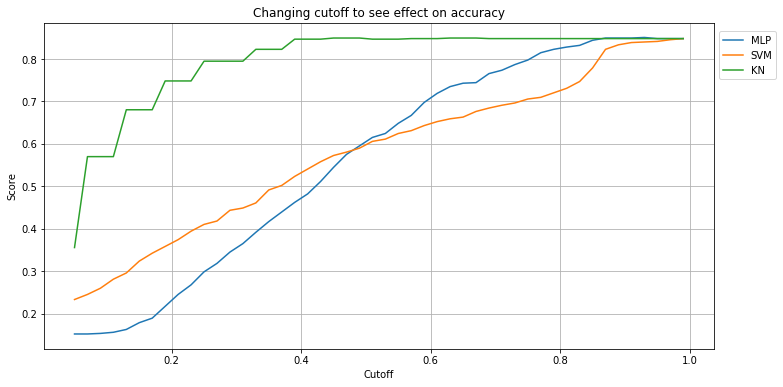

In [94]:
#accuracy graph 
plt.figure(figsize=(12, 6))

plt.plot(range_x, results_MLP['accuracy'], label='MLP')
plt.plot(range_x, results_SVM['accuracy'], label='SVM')
plt.plot(range_x, results_KN['accuracy'], label ='KN')
    
    
plt.grid()
plt.title('Changing cutoff to see effect on accuracy')
plt.xlabel('Cutoff')
plt.ylabel('Score')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.9))



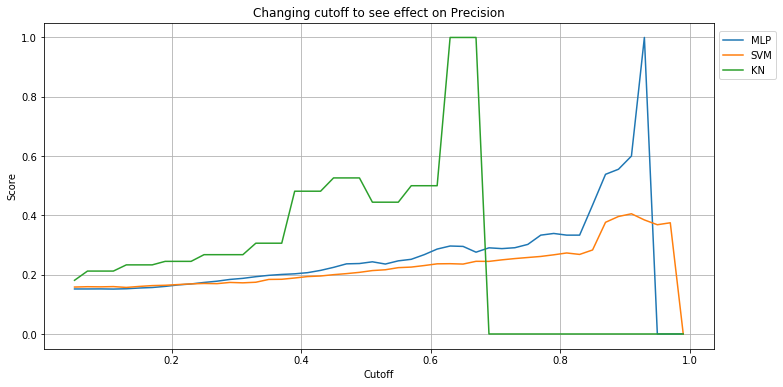

In [99]:
#Precision Graph 
plt.figure(figsize=(12, 6))

plt.plot(range_x, results_MLP['precision'], label='MLP')
plt.plot(range_x, results_SVM['precision'], label='SVM')
plt.plot(range_x, results_KN['precision'], label ='KN')
    
    
plt.grid()
plt.title('Changing cutoff to see effect on Precision')
plt.xlabel('Cutoff')
plt.ylabel('Score')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.9))

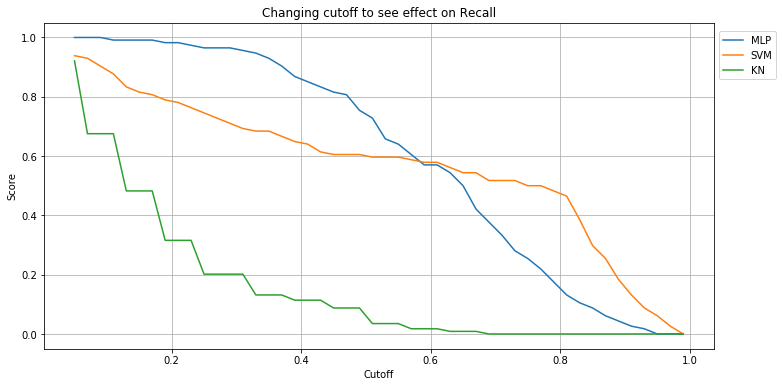

In [98]:
#Recall Graph 
plt.figure(figsize=(12, 6))

plt.plot(range_x, results_MLP['recall'], label='MLP')
plt.plot(range_x, results_SVM['recall'], label='SVM')
plt.plot(range_x, results_KN['recall'], label ='KN')
    
    
plt.grid()
plt.title('Changing cutoff to see effect on Recall')
plt.xlabel('Cutoff')
plt.ylabel('Score')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.9))

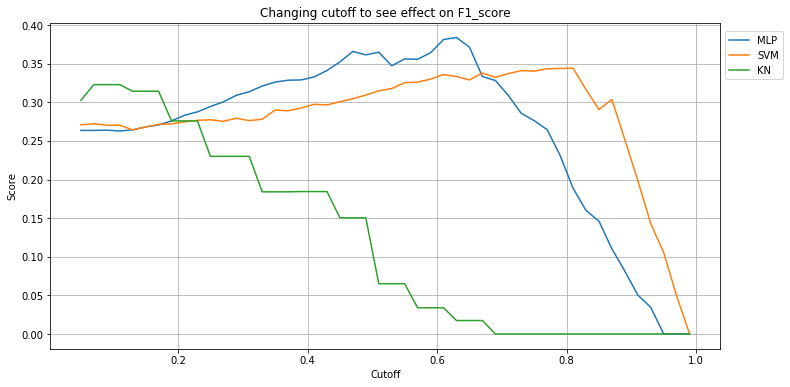

In [104]:
#F1_score Graph 
plt.figure(figsize=(12, 6))

plt.plot(range_x, results_MLP['f1'], label='MLP')
plt.plot(range_x, results_SVM['f1'], label='SVM')
plt.plot(range_x, results_KN['f1'], label ='KN')
    
    
plt.grid()
plt.title('Changing cutoff to see effect on F1_score')
plt.xlabel('Cutoff')
plt.ylabel('Score')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.9))